# Loading checkpoint of trained model

In [1]:
import torch

In [2]:
ckpt = torch.load('results/bV10_sample_c_hess/hess_bsize1024_lr3en5_j72_h1en4_3/ckpt_last.pt')

In [3]:
ckpt

{'args': Namespace(H_weight=0.0001, J_weight=72.0, L0=None, anneal_steps=12, bV_dim=10, batch_normalize_loss=False, batch_size=1024, boundary_amp_scale=0.25, boundary_ax_scale=0.3, boundary_freq_scale=20.0, boundary_gauss_scale=0.1, boundary_shear_scale=0.05, boundary_sin_scale=0.3, c1=0.0, c1_high=0.1, c1_low=-0.1, c2=0.0, c2_high=0.1, c2_low=-0.1, clip_grad_norm=0.01, dagger=False, data_name='bV10_sample_c_hess', deploy=True, deploy_error_alpha=0.9, experiment_name='hess_bsize1024_lr3en5_j72_h1en4', ffn_layer_sizes='[256,128,64,32]', fix_normalizer=True, force_amp_scale=0.0, force_freq_scale=0.0, hess=True, init='xavier', log_scale=True, lr=3e-05, max_collectors=0, max_evaluators=4, max_newton_iter=1000, max_train_steps=10000000, metamaterial_mesh_size=16, min_feature_size=0.15, n_cells=2, n_safe=0, nonlinearity='selu', normalizer_alpha=0.999, optimizer='adam', poisson_ratio=0.49, pore_radial_resolution=120, porosity=0.5, quadratic_scale=True, relaxation_parameter=0.1, reload_data=Tr

# Imports

In [4]:
from src.arguments import parser
from src import fa_combined as fa
from src.pde.metamaterial import Metamaterial
from src.maps.function_space_map import FunctionSpaceMap
from src.nets.feed_forward_net import FeedForwardNet
from src.energy_model.surrogate_energy_model import SurrogateEnergyModel
from src.energy_model.composed_energy_model import ComposedEnergyModel
from src.energy_model.composed_fenics_energy_model import ComposedFenicsEnergyModel

# Collect args from checkpoint

In [5]:
args = ckpt['args']

# Construct PDE and fsm. Reload net from checkpoint

In [6]:
pde = Metamaterial(args)
fsm = FunctionSpaceMap(pde.V, args.bV_dim, cuda=True)
net = FeedForwardNet(args, fsm)
net = net.cuda()
net.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

# Create Energy Models for composed-cell deployment

In [7]:
import numpy as np

RVES_WIDTH = 4

sem = SurrogateEnergyModel(args, net, fsm)
cem = ComposedEnergyModel(args, sem, RVES_WIDTH, RVES_WIDTH)

cfem = ComposedFenicsEnergyModel(args, RVES_WIDTH, RVES_WIDTH,
                                 np.zeros(RVES_WIDTH*RVES_WIDTH),
                                 np.zeros(RVES_WIDTH*RVES_WIDTH))

# Construct constraints

In [8]:
cem_constraint_mask = torch.zeros(len(cem.global_coords))
cem_constraint_mask[cem.bot_idxs()] = 1.0
cem_constraint_mask[cem.top_idxs()] = 1.0
force_data = torch.zeros(len(cem.global_coords), 2)
constrained_sides = [True, False, True, False]


MAX_DISP = -0.125


# Do Fenics solve. This might take some time.

In [9]:
init_guess = np.array(fa.Function(cfem.pde.V).vector()[:])


# Tune anneal steps and relaxation parameter to get max speed without solution blowing up
ANNEAL_STEPS = 10
args.relaxation_parameter = 0.1

# This will make Fenics print solve progress
# (But it prints to the bash session running Jupyter, not this notebook)
fa.set_log_level(20)

for i in range(ANNEAL_STEPS):
    print("Anneal {} of {}".format(i+1, ANNEAL_STEPS))
    fenics_boundary_fn = fa.Expression(('0.0', 'X*x[1]'),
                                   element=pde.V.ufl_element(),
                                    X=MAX_DISP*(i+1)/ANNEAL_STEPS)

    true_soln = cfem.solve(args=args, boundary_fn=fenics_boundary_fn,
                           constrained_sides=constrained_sides,
                           initial_guess=init_guess)
    init_guess = true_soln.vector()
    

Anneal 1 of 10
Anneal 2 of 10
Anneal 3 of 10
Anneal 4 of 10
Anneal 5 of 10
Anneal 6 of 10
Anneal 7 of 10
Anneal 8 of 10
Anneal 9 of 10
Anneal 10 of 10


In [10]:
true_soln

Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 591), VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2)), 4597)

NameError: name 'surr_soln' is not defined

# Do surrogate solve

In [12]:
boundary_data = torch.zeros(len(cem.global_coords), 2)
boundary_data[:, 1] = MAX_DISP * torch.Tensor(cem.global_coords)[:, 1]
params = torch.zeros(RVES_WIDTH*RVES_WIDTH, 2)

In [13]:
boundary_data[:, 1]

tensor([-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000,
        -0.0000, -0.0000, -0.0139, -0.0278, -0.0417, -0.0556, -0.0694, -0.0833,
        -0.0972, -0.1111, -0.1250, -0.1250, -0.1250, -0.1250, -0.1250, -0.1250,
        -0.1250, -0.1250, -0.1250, -0.1250, -0.1111, -0.0972, -0.0833, -0.0694,
        -0.0556, -0.0417, -0.0278, -0.0139, -0.1389, -0.1528, -0.1667, -0.1806,
        -0.1944, -0.2083, -0.2222, -0.2361, -0.2500, -0.2500, -0.2500, -0.2500,
        -0.2500, -0.2500, -0.2500, -0.2500, -0.2500, -0.2500, -0.2361, -0.2222,
        -0.2083, -0.1944, -0.1806, -0.1667, -0.1528, -0.1389, -0.2639, -0.2778,
        -0.2917, -0.3056, -0.3194, -0.3333, -0.3472, -0.3611, -0.3750, -0.3750,
        -0.3750, -0.3750, -0.3750, -0.3750, -0.3750, -0.3750, -0.3750, -0.3750,
        -0.3611, -0.3472, -0.3333, -0.3194, -0.3056, -0.2917, -0.2778, -0.2639,
        -0.3889, -0.4028, -0.4167, -0.4306, -0.4444, -0.4583, -0.4722, -0.4861,
        -0.5000, -0.5000, -0.5000, -0.50

In [14]:
surr_soln = cem.solve(params.cuda(), boundary_data.cuda(),
                      cem_constraint_mask.cuda(), force_data.cuda(),
                      opt_steps=10000)

# Plot the reference, true solution, and surrogate solution

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

initial_coords = np.array(cem.global_coords)

surr_final_coords = np.array(cem.global_coords) + surr_soln.data.cpu().numpy()

true_final_coords = initial_coords + np.array([true_soln(*x) for x in initial_coords])

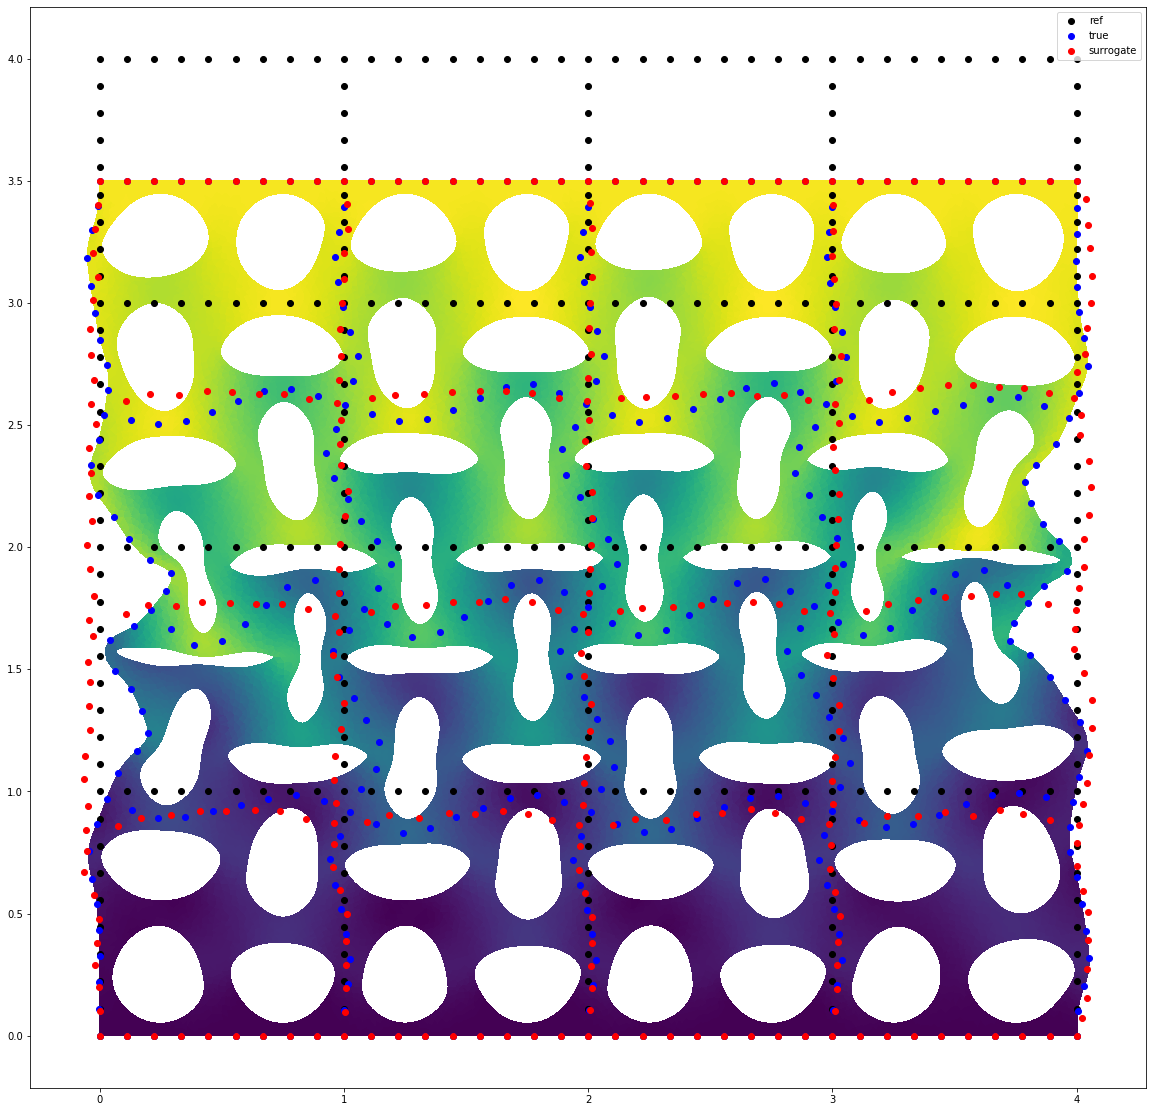

In [18]:
plt.figure(figsize=(20,20))
fa.plot(true_soln, mode='displacement')
plt.scatter(initial_coords[:, 0], initial_coords[:, 1], color='k', label='ref')
plt.scatter(true_final_coords[:, 0], true_final_coords[:, 1], color='b', label='true')
plt.scatter(surr_final_coords[:, 0], surr_final_coords[:, 1], color='r', label='surrogate')
plt.legend()
plt.show()

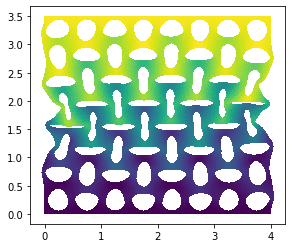

In [17]:
fa.plot(true_soln, mode='displacement')